In [1]:
#import block
import tensorflow as tf
from tensorflow import keras
import h5py
import numpy as np
import json
import pandas as pd
from matplotlib import pyplot as plt

2021-11-30 16:18:47.850037: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 16:18:47.850057: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Function block for grabbing a section of the data
def grabData(start=0, stop=0, step=8):
  if(stop == 0):
    samples = hdf5_file['X'][start::step]
    modulation_classes = hdf5_file['Y'][start::step]
    snr = hdf5_file['Z'][start::step]
  else:
    samples = hdf5_file['X'][start:stop:step]
    modulation_classes = hdf5_file['Y'][start:stop:step]
    snr = hdf5_file['Z'][start:stop:step]

  mod_array = np.zeros(len(modulation_classes))
  i = 0
  for x in modulation_classes:
    mod_array[i] = np.where(x==1)[0][0]
    i = i + 1

  return samples, mod_array, snr

In [3]:
##code block for loading in DeepSig data from hdf5 file

# Open the dataset
# hdf5_file = h5py.File("/content/content/DeepSig_shuffled/DeepSig_XYZ_OSC.0001_1024_Shuffled.hdf5",  'r')
hdf5_file = h5py.File("../dataset/GOLD_XYZ_OSC.0001_1024.hdf5",  'r')

# Load the modulation classes. You can also copy and paste the content of classes-fixed.txt.
# modulation_classes = json.load(open("/content/content/DeepSig_shuffled/classes-fixed.json", 'r'))
modulation_classes = json.load(open("../dataset/classes-fixed.json", 'r'))

#List groups of the hdf5 file
list(hdf5_file.keys())
#DeepSig image input shape
img_width, img_height, img_channels = (1024, 2, 1)

In [4]:
print(hdf5_file)

<HDF5 file "GOLD_XYZ_OSC.0001_1024.hdf5" (mode r)>


In [5]:
# creates subset of source for mod_scheme
modulation_map = {k: float(v) for v, k in enumerate(modulation_classes)}
print(modulation_map)
def createModulationList(source, mod_scheme):
    mod_num = modulation_map[mod_scheme]
    return [s[0] for s in source if (s[1] == mod_num)]
    

{'OOK': 0.0, '4ASK': 1.0, '8ASK': 2.0, 'BPSK': 3.0, 'QPSK': 4.0, '8PSK': 5.0, '16PSK': 6.0, '32PSK': 7.0, '16APSK': 8.0, '32APSK': 9.0, '64APSK': 10.0, '128APSK': 11.0, '16QAM': 12.0, '32QAM': 13.0, '64QAM': 14.0, '128QAM': 15.0, '256QAM': 16.0, 'AM-SSB-WC': 17.0, 'AM-SSB-SC': 18.0, 'AM-DSB-WC': 19.0, 'AM-DSB-SC': 20.0, 'FM': 21.0, 'GMSK': 22.0, 'OQPSK': 23.0}


In [6]:
# define data to use for testing and format for easy seperation by modulation scheme
test_data = grabData(step=32)
test_data = tuple(zip(test_data[0], test_data[1]))

test_OOK = createModulationList(test_data, 'OOK')
print(len(test_OOK))
print(test_OOK[0])

3328
[[ 0.0420274   0.23476323]
 [-0.2728826   0.40513492]
 [-0.26707262  0.22749889]
 ...
 [-0.7055947  -0.28693035]
 [-0.41157472  0.66826206]
 [ 0.06487698  0.6358149 ]]


In [7]:
import matplotlib.pyplot as plt
pie_keys = modulation_map.keys()
def plotDist(mod_type, stats):
    plt.style.use('seaborn-dark')
    plt.pie(stats)
    
    # use a list comprehension to update the labels
    labels = [f'{l}, {(s/len(stats)):0.1f}%' for l, s in zip(pie_keys, stats)]
    
    plt.legend(bbox_to_anchor=(1.5, 1), loc='upper left', labels=labels)
    plt.show()

In [8]:
# test model accuracy with each modulation scheme
def testAccuracy(model, test_data):
    for m in modulation_map.items():
        test_mod = createModulationList(test_data, m[0])
        test_mod = np.array(test_mod)
        results = model.predict(test_mod) 
        predictions = [p.argmax() for p in results]
        prediction_dist = [sum(x) for x in zip(*results)] # list of sums for each modulation type
        print(f'{m[0]} accuracy {"{:.2%}".format(predictions.count(m[1])/len(results))}')
        plotDist(m[0], prediction_dist)

testing five_layers:


2021-11-30 16:18:49.659108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-30 16:18:49.659128: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-30 16:18:49.659144: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bolt): /proc/driver/nvidia/version does not exist
2021-11-30 16:18:49.659277: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-30 16:18:50.072591: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimizat

OOK accuracy 71.72%


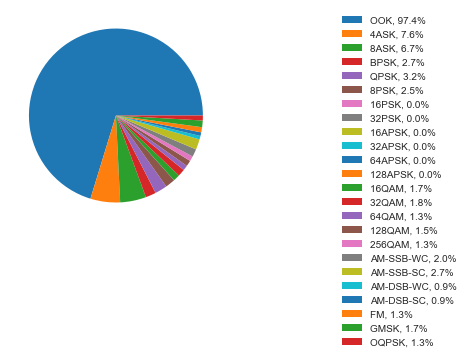

4ASK accuracy 59.25%


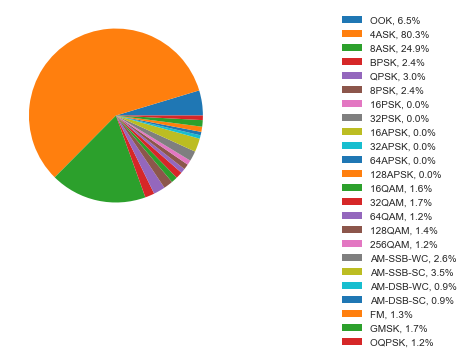

8ASK accuracy 72.36%


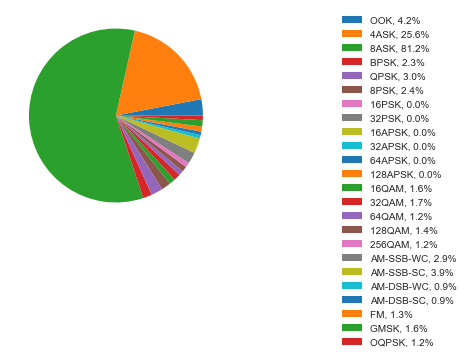

BPSK accuracy 76.05%


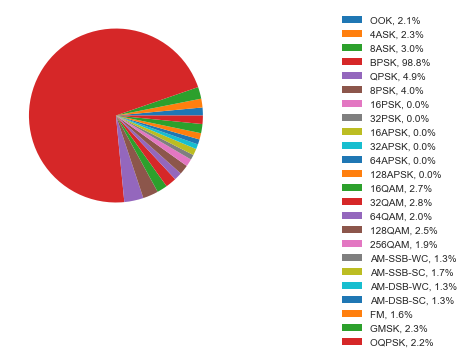

QPSK accuracy 71.97%


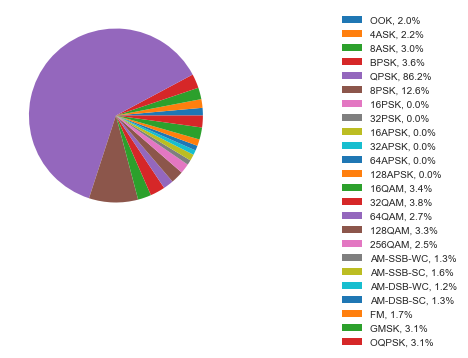

8PSK accuracy 69.68%


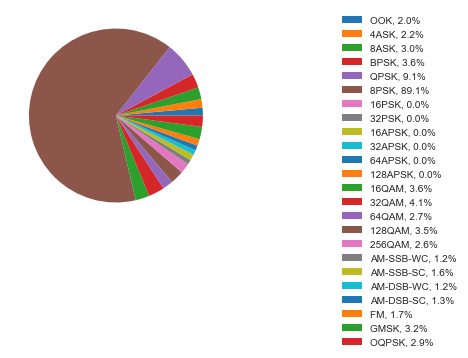

16PSK accuracy 0.00%


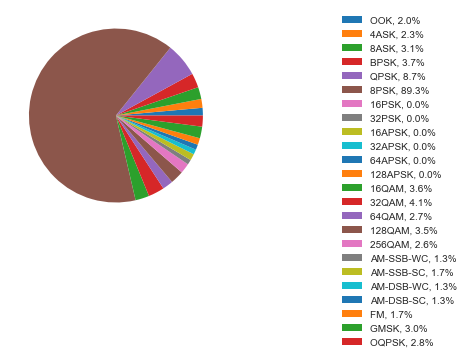

32PSK accuracy 0.00%


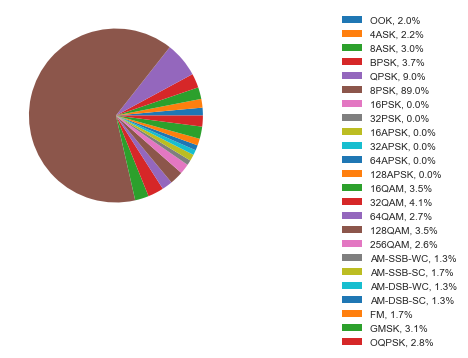

16APSK accuracy 0.00%


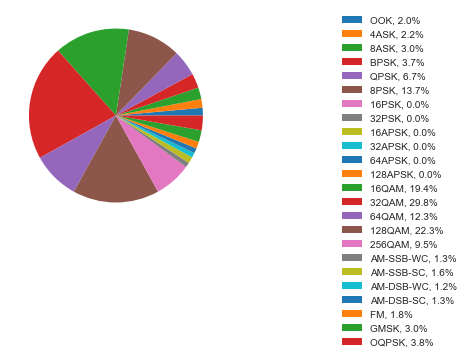

32APSK accuracy 0.00%


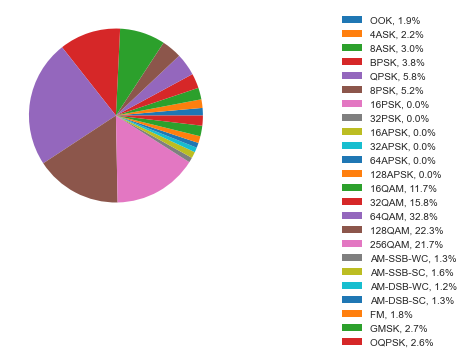

64APSK accuracy 0.00%


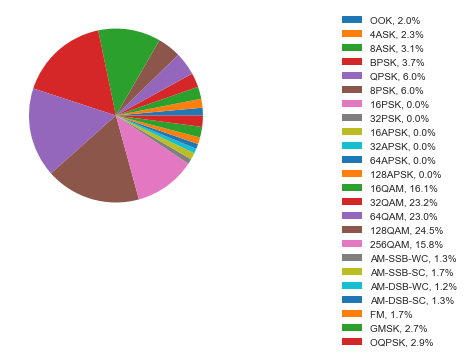

128APSK accuracy 0.00%


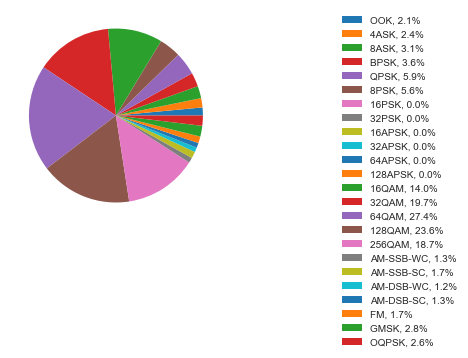

16QAM accuracy 3.88%


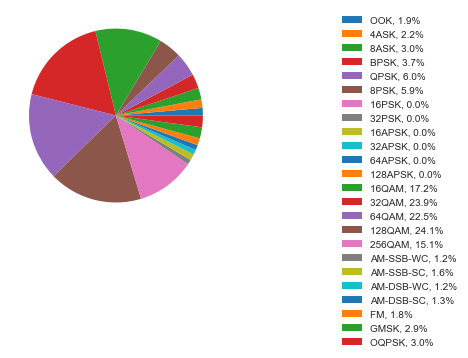

32QAM accuracy 22.51%


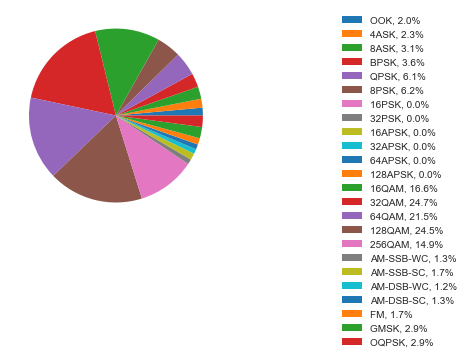

64QAM accuracy 29.66%


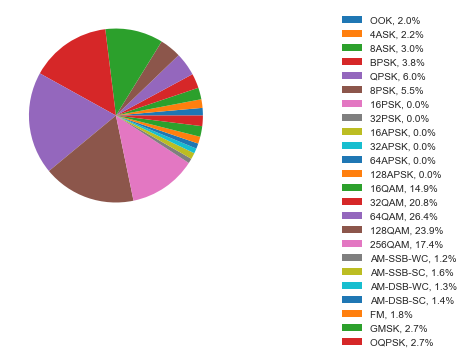

128QAM accuracy 20.52%


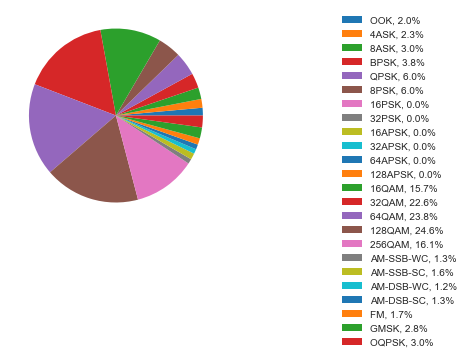

256QAM accuracy 4.24%


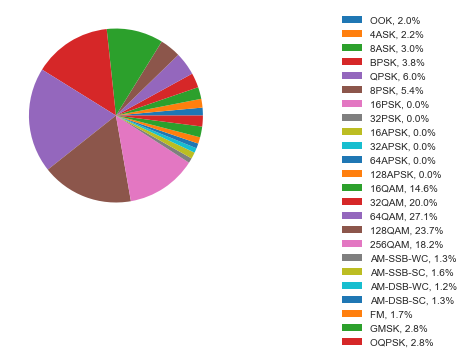

AM-SSB-WC accuracy 17.52%


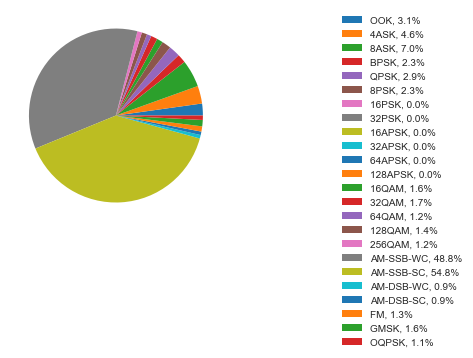

AM-SSB-SC accuracy 69.83%


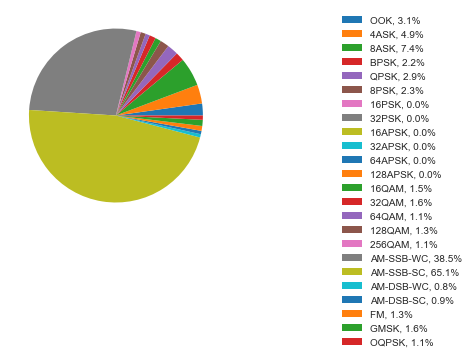

AM-DSB-WC accuracy 73.35%


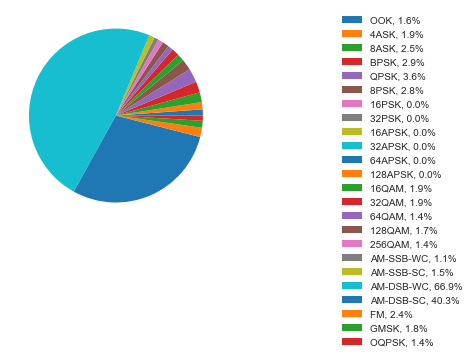

AM-DSB-SC accuracy 5.29%


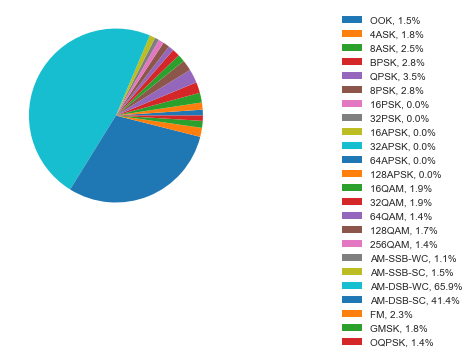

FM accuracy 79.87%


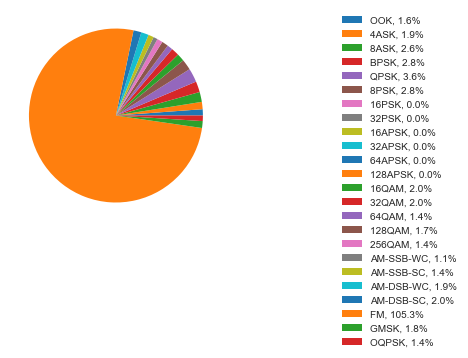

GMSK accuracy 66.23%


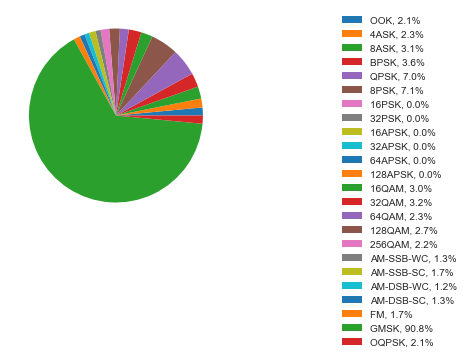

OQPSK accuracy 62.74%


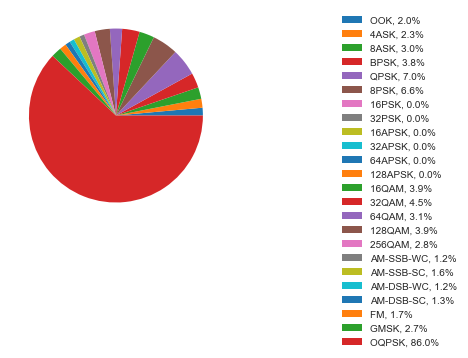

In [9]:
# model_list = ['five_layers', 'six_layers', 'seven_layers', 'eight_layers']
model_list = ['five_layers']
for model in model_list:
    print('=========================================\n' + f'testing {model}:')
    model = keras.models.load_model(f'./models/{model}')
    testAccuracy(model, test_data)